# Wind turbine database

The USGS [hosts a Wind Turbine database](https://eerscmap.usgs.gov/uswtdb/) (See the External Resources section at the [DOI](https://doi.org/10.5066/F7TX3DN0)) in a handy CSV format.

As of 17 Jan 2023, from that page, click `Get Data` at the top to go to [the data page](https://eerscmap.usgs.gov/uswtdb/data/). There, you'll find a link to a zipped version of the CSV file.

Let's download a copy of the most recent version. I've copied the direct-access URL below, which might need to be updated as the version changes.

In [1]:
import urllib.request
turbines_v52 = "https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbCSV.zip"
urllib.request.urlretrieve(turbines_v52, "uswtdbCSV.zip")

('uswtdbCSV.zip', <http.client.HTTPMessage at 0x109665f90>)

This will download a copy of the zip to this directory. You can unzip it manually, find the CSV file, put it at the root level of this directory, and rename it to `turbine_locations.csv`, but the code below will automatically do that for us.

In [2]:
import zipfile
zipdata = zipfile.ZipFile('uswtdbCSV.zip')
zipinfos = zipdata.infolist()

# iterate through each file
for zipinfo in zipinfos:
    # This will do the renaming
    if '.csv' in zipinfo.filename:
        print("Found ", zipinfo.filename)
    # We can override the filename. Neat!
    zipinfo.filename = 'turbine_locations.csv'
    zipdata.extract(zipinfo)


Found  uswtdb_v5_3_20230113.csv


## Plot directly from a gridded NetCDF file that also has events and flashes in it. 

This notebook uses the grid times directly to set the time limits.

In [3]:
%matplotlib widget

In [4]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import glob
import os
import pandas as pd
import datetime

from pyxlma.lmalib.io import read as lma_read
# from pyxlma.plot.xlma_plot_feature import color_by_time, plot_points, setup_hist, plot_3d_grid, subset
# from pyxlma.plot.xlma_base_plot import subplot_labels, inset_view, BlankPlot
from pyxlma.plot.interactive import InteractiveLMAPlot
from pyxlma.plot.interactive import output as lma_plot_output
import matplotlib.dates as md

In [5]:
ds = xr.open_dataset('./LYLOUT_221120_080000_14400_map4000m.nc')
starttime, endtime = ds.grid_time_edge[0].data, ds.grid_time_edge[-1].data

In [6]:
print(starttime, endtime)
print(ds.event_chi2.attrs['valid_range'])
print(ds.event_stations.attrs['valid_range'])
ds

2022-11-20T08:00:00.000000000 2022-11-20T12:00:00.000000000
[0. 5.]
[  5 255]


<xarray.Dataset>
Dimensions:                               (grid_x_edge: 76, grid_x: 75,
                                           grid_y_edge: 76, grid_y: 75,
                                           grid_time_edge: 49, grid_time: 48,
                                           number_of_flashes: 106,
                                           number_of_stations: 16,
                                           number_of_events: 10432)
Coordinates: (12/16)
  * grid_x_edge                           (grid_x_edge) float64 -1.5e+05 ... ...
  * grid_x                                (grid_x) float64 -1.48e+05 ... 1.48...
  * grid_y_edge                           (grid_y_edge) float64 -1.5e+05 ... ...
  * grid_y                                (grid_y) float64 -1.48e+05 ... 1.48...
  * grid_time_edge                        (grid_time_edge) datetime64[ns] 202...
  * grid_time                             (grid_time) datetime64[ns] 2022-11-...
    ...                                    ...
    event_id                              (number_of_events) uint64 ...
    flash_time_start                      (number_of_flashes) datetime64[ns] ...
    flash_init_latitude                   (number_of_flashes) float32 ...
    flash_init_longitude                  (number_of_flashes) float32 ...
    flash_init_altitude                   (number_of_flashes) float32 ...
    flash_id                              (number_of_flashes) uint64 ...
Dimensions without coordinates: number_of_stations, number_of_events
Data variables: (12/47)
    flash_extent_density                  (grid_time, grid_y, grid_x) float64 ...
    average_flash_area                    (grid_time, grid_y, grid_x) float64 ...
    stdev_flash_area                      (grid_time, grid_y, grid_x) float64 ...
    minimum_flash_area                    (grid_time, grid_y, grid_x) float64 ...
    average_flash_energy                  (grid_time, grid_y, grid_x) float64 ...
    event_count                           (grid_time, grid_y, grid_x) float64 ...
    ...                                    ...
    flash_init_x                          (number_of_flashes) float64 ...
    flash_init_y                          (number_of_flashes) float64 ...
    flash_ctr_x                           (number_of_flashes) float64 ...
    flash_ctr_y                           (number_of_flashes) float64 ...
    lon                                   (grid_y, grid_x) float64 ...
    lat                                   (grid_y, grid_x) float64 ...
Attributes:
    source:                   VHF Lightning Mapping Array
    event_algorithm_name:      ./lma_analysis -d 20221120 -t 080000 -s 600 -l...
    flash_algorithm_name:     pyxlma DBSCAN
    production_site:          Default
    production_date:          2023-01-04 20:14:31 +00:00
    comment:                  
    flash_algorithm_version:  0.1
    institution:              unknown
    references:               
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_version:   10.14.5R
    history:                  LMA source file created  Mon Nov 21 08:48:02 20...

In [7]:
lma_ctr_lon, lma_ctr_lat = ds.network_center_longitude.data, ds.network_center_latitude.data

# A fully interactive plot that synchronizes all axes

`xlma-python` has a new feature as of fall 2022 that enables interactive zooming/panning on any plot in a way that automates replotting all of the other panels.

We can also overlay our own data on the plot, which is useful for things like balloon tracks and radar scans. There are examples of doing so from the TRACER field campaign, so before you go writing your own code for that, [reach out](mailto:eric.bruning@ttu.edu)!

In [8]:
OSW_lat, OSW_lon = 43.454722, -76.506667
Lowville_lat, Lowville_lon = 43.786667, -75.492222
KTYX_lat, KTYX_lon, KTYX_alt = 43.7558, -75.68, 562.0

station_lons = [OSW_lon, Lowville_lon, KTYX_lon]
station_lats = [OSW_lat, Lowville_lat, KTYX_lat]
station_labels = ['Oswego', 'Lowville', 'KTYX']

In [9]:
# Manually set the encoding because someone didn't use UTF-8 like they should have.
turbines = pd.read_csv('turbine_locations.csv', encoding = "ISO-8859-1")
nearby_turbines = ((turbines.xlong > lma_ctr_lon - 3.0) & (turbines.xlong < lma_ctr_lon + 3.0) &
                   (turbines.ylat > lma_ctr_lat - 3.0) & (turbines.ylat < lma_ctr_lat + 3.0))
turbines = turbines[nearby_turbines]
turbines

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_rsa,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
1826,3028138,42-020491,2008-WTE-4523-OE,38038.0,57044.0,PA,Tioga County,42117,Armenia Mountain,2009.0,...,4656.63,118.6,0,NaN,3,3,1/1/2010,NAIP,-76.962799,41.739990
1827,3028147,42-020481,2008-WTE-4532-OE,38056.0,57044.0,PA,Tioga County,42117,Armenia Mountain,2009.0,...,4656.63,118.6,0,NaN,3,3,1/1/2010,NAIP,-76.941895,41.750492
1828,3030841,42-020470,2009-WTE-5013-OE,38035.0,57044.0,PA,Bradford County,42015,Armenia Mountain,2009.0,...,4656.63,118.6,0,NaN,3,3,1/1/2010,NAIP,-76.846901,41.737694
1829,3028140,42-020489,2008-WTE-4525-OE,38037.0,57044.0,PA,Tioga County,42117,Armenia Mountain,2009.0,...,4656.63,118.6,0,NaN,3,3,1/1/2010,NAIP,-76.953300,41.738792
1830,3028137,42-020492,2008-WTE-4522-OE,38036.0,57044.0,PA,Tioga County,42117,Armenia Mountain,2009.0,...,4656.63,118.6,0,NaN,3,3,1/1/2010,NAIP,-76.965096,41.738792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71411,3126079,36-197744,2019-WTE-9495-OE,NaN,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,...,NaN,NaN,0,NaN,1,1,10/28/2021,Digital Globe,-77.533653,42.461494
71412,3124547,36-197725,2019-WTE-9468-OE,NaN,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,...,NaN,NaN,0,NaN,1,1,1/31/2022,Digital Globe,-77.512711,42.470379
71413,3125996,36-197736,2019-WTE-9485-OE,NaN,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,...,NaN,NaN,0,NaN,1,1,10/28/2021,Digital Globe,-77.549110,42.478436
71414,3124551,36-197727,2019-WTE-9470-OE,NaN,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,...,NaN,NaN,0,NaN,1,1,1/31/2022,Digital Globe,-77.512199,42.480721


In [10]:
class AnnotatedLMAPlot(InteractiveLMAPlot):
    # @output.capture()
    def make_plot(self):
        # Use the built-in LMA functionality
        super(AnnotatedLMAPlot, self).make_plot()
        
        # Add our own title
        tlim = self.bounds['t']
        tlim_sub = pd.to_datetime(tlim[0]), pd.to_datetime(tlim[1])
        title = tlim_sub[0].strftime('%Y%m%d %H%M%S') + ' to ' + tlim_sub[1].strftime('%Y%m%d %H%M%S') + ' UTC'
        self.lma_plot.ax_th.set_title(title)
        
        # Could use if we want to change how plotting works for shorter periods of time.
        plot_duration_sec = (tlim[1]-tlim[0]).total_seconds()
        
        # Add the station positions we defined above, and label them. We only need to add them to the plan-view plot.
        # The other axes are self.lma_plot.ax_th, .ax_lon, and .ax_lat.
        new_artists = []
        art = self.lma_plot.ax_plan.scatter(station_lons, station_lats, color='k', zorder=-10)
        new_artists.append(art)
        for slon,slat,slabel in zip(station_lons, station_lats, station_labels):
            txt_art = self.lma_plot.ax_plan.text(slon, slat, slabel)
            new_artists.append(txt_art)
        
        # Add the wind turbines. We don't worry about filtering to just those in the plot,
        # though we could do that here using 
        turbine_color=(0,0,1.0,0.3)
        art = self.lma_plot.ax_plan.scatter(turbines.xlong, turbines.ylat, color=turbine_color, marker='1', zorder=-10)
        new_artists.append(art)

        self.data_artists.extend(new_artists)

/Users/ebruning/miniconda3/envs/leelma/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:801: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


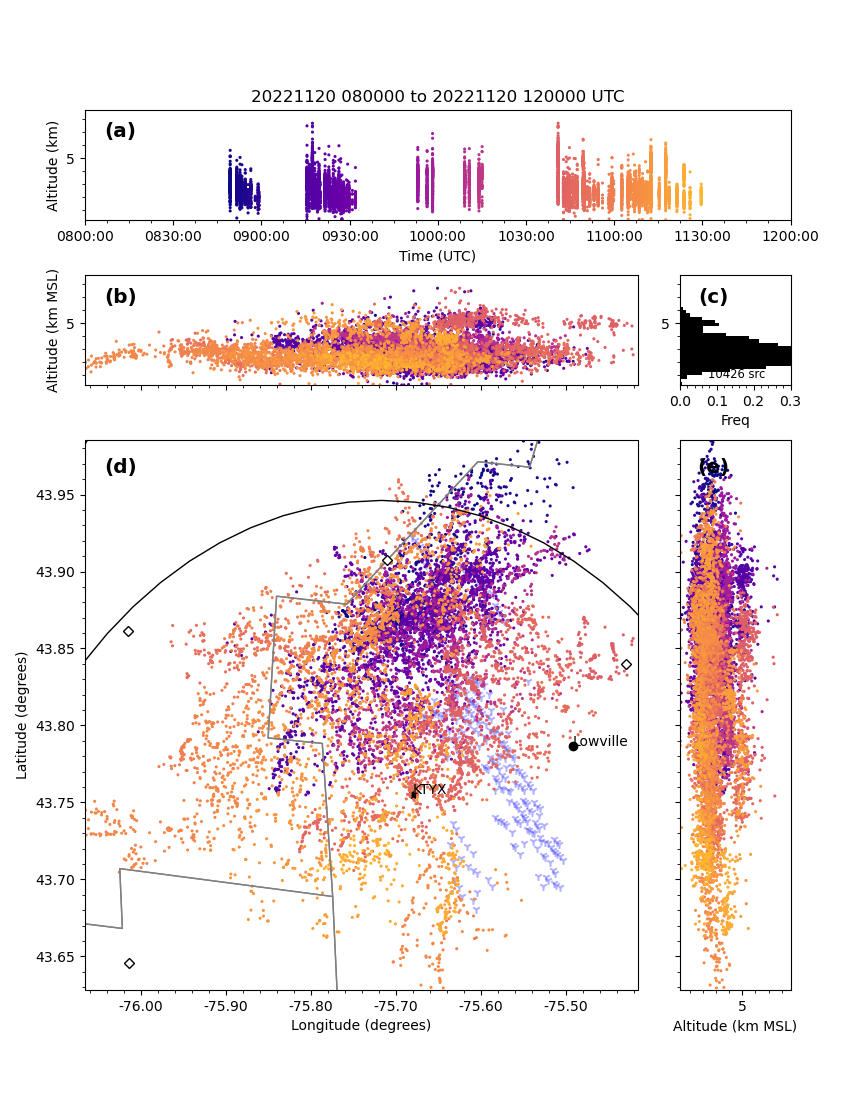

In [11]:
tlim = pd.to_datetime(starttime).to_pydatetime(), pd.to_datetime(endtime).to_pydatetime()
interactive_lma = AnnotatedLMAPlot(ds, clon=lma_ctr_lon, clat=lma_ctr_lat, tlim=tlim)

# Simpler version with no overlays
# interactive_lma = InteractiveLMAPlot(ds)

In [12]:
# print the current view
print(interactive_lma.bounds)

{'x': (array(-76.06597, dtype=float32), array(-75.415924, dtype=float32)), 'y': (array(43.62815, dtype=float32), array(43.985443, dtype=float32)), 'z': (0.26645999145507815, 8.6723095703125), 't': (datetime.datetime(2022, 11, 20, 8, 0), datetime.datetime(2022, 11, 20, 12, 0))}


# Zoom to an interesting flash

Unlike many of the discharges that started at the turbines, which appear to have only an upward-positive leader, this discharge has an additional negative leader mapped above 5 km. Some similar discharges were reported by [Schultz et al. (2018, JGR)](https://dx.doi.org/10.1002/2017JD027821).

Cool flash that we found with two layers of charge.

In [13]:
first_bilevel_turbine_discharge = {'x': (-76.06597137451172, -75.41592407226562),
                                   'y': (43.628150939941406, 43.985443115234375),
                                   'z': (0.26645999145507815, 8.012563424733926),
                                   't': (datetime.datetime(2022, 11, 20, 9, 17, 22, 300804), 
                                         datetime.datetime(2022, 11, 20, 9, 17, 23, 416886))}

In [14]:
bilevel_turbine_discharge = {'x': (-75.77359715802638, -75.41592407226562), 
                             'y': (43.744758113514294, 43.93055004466664), 
                             'z': (0.5122845152725404, 7.88702022979632), 
                             't': (datetime.datetime(2022, 11, 20, 10, 40, 56, 102676), 
                                   datetime.datetime(2022, 11, 20, 10, 40, 56, 929403))}

In [15]:
interactive_lma.lma_plot.ax_th.set_xlim(bilevel_turbine_discharge['t'], emit=False)
interactive_lma.lma_plot.ax_th.set_ylim(bilevel_turbine_discharge['z'], emit=False)
interactive_lma.lma_plot.ax_plan.set_xlim(bilevel_turbine_discharge['x'], emit=False)
interactive_lma.lma_plot.ax_plan.set_ylim(bilevel_turbine_discharge['y'])

(43.744758113514294, 43.93055004466664)